<a id='logbook'></a>
# Roll decay damping
This is the notebook that created the report.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import sympy as sp

import pandas as pd
import numpy as np

if os.name == 'nt':
    plt.style.use('paper.mplstyle')  # Windows

import statsmodels.api as sm
from sklearn.metrics import r2_score
from scipy.integrate import solve_ivp

from copy import deepcopy
from src.notebook_to_latex import Equation, equation_dict
from src import equations,symbols
import reports.paper_writing
from src.df_to_latex import LateXTable
from src.data.helpers import load
from src.visualization import rolldecay
import src.visualization.regression
from src.simulation import simulate
from src.models import regression

from rolldecayestimators.substitute_dynamic_symbols import run,lambdify

## Examples:


Duplicate key in file 'paper.mplstyle', line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file 'paper.mplstyle', line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','png')
from IPython.display import HTML, Markdown, Image
from src.df_to_latex import LateXTable

# Abstract
The roll damping of a ship is determined with time series from scale model roll decay tests using a parameter identification technique (PIT).

# Introduction
The present dataset contains roll decay tests from actual model tests, carried out at SSPA maritime-dynamics-laboratory (www.sspa.se) and also CFD simulations, using a method called FNPF. The roll damping is determined by identifying the roll damping parameters in a prescribed mathematical model for the decaying roll motion. The roll angle time series from a roll decay model test is shown in Fig.[(below)](#fig_rolldecay_example)

<a id='fig_rolldecay_example>'></a>

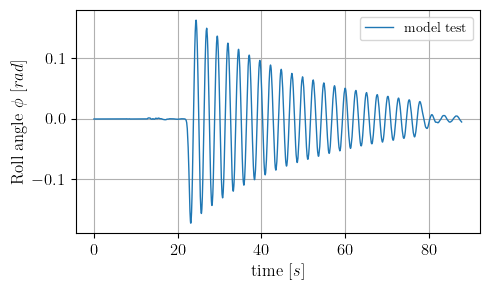

In [4]:
data = pd.read_csv('../../data/external/model_test_21340.csv', index_col=0)
fig,ax=plt.subplots()
data.plot(y='phi', ax=ax, label='model test');
ax.set_ylabel(r'Roll angle $\phi$ $[rad]$')
ax.set_xlabel(r'time $[s]$')
ax.grid(True)

The oscillating motion can be described by a spring-mass-damper system as seen in Fig.[(below)](#fig_spring_mass_damper).

<a id="fig_spring_mass_damper"></a>

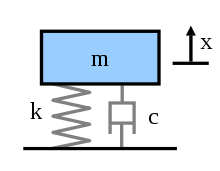

In [5]:
Image('../figures/220px-Mass_spring_damper.svg.png')

This system can me described as the following ordinary differential equation:

In [6]:
Equation(equations.roll_decay_equation_general_himeno, label='eq:roll_decay_equation_general_himeno')

<src.notebook_to_latex.Equation object>

Where $B_{44}(\dot{\phi})$ and $C_{44}(\phi)$ are the damping and stiffness models. A cubic model can be obtained by using cubic damping:

In [7]:
Equation(equations.b44_cubic_equation, label='eq:b44_cubic_equation')

<src.notebook_to_latex.Equation object>

And cubic stiffness model:

In [8]:
Equation(equations.restoring_equation_cubic, label='eq:restoring_equation_cubic')

<src.notebook_to_latex.Equation object>

The total equation is then written:

In [9]:
Equation(equations.roll_decay_equation_quadratic_, label='eq:roll_decay_equation_quadratic', max_length=200)

<src.notebook_to_latex.Equation object>

This equation does not have one unique solution however. If all parameters would be  multiplied by a factor $k$ these parameters would also yield as a solution to the equation. All parameters are therefore divided by the total inertia $A_{44}$ (including added mass inertia), replacing the parameters with new normalized parameters such as: $B_{1A} = B_1/A_{44}$. The equation is now rewritten with these new parameters which have unique solutions:

<a id="eq_eq:roll_decay_equation_quadratic_A"></a>

In [10]:
Equation(equations.roll_decay_equation_quadratic_A, label='eq:roll_decay_equation_quadratic_A', max_length=200)

<src.notebook_to_latex.Equation object>

In [11]:
B_1A, B_2A, B_3A, C_1A, C_3A, C_5A = sp.symbols('B_1A, B_2A, B_3A, C_1A, C_3A, C_5A')

# Data
The data used in this study is described in Tab.[(below)](#tab_data_files). There is one result with a pure FNPF simulation at 0 knots. For model test results, two tests are available at 0 knots and one test at 15.5 knots. There is also a result at 15.5 with a hybrid method, where semi empirical viscosity has been injected into the FNPF calculations.

<a id="tab_data_files"></a>

In [12]:
content = pd.read_csv('../../data/external/content.csv', sep=';')
table_parameters = content.round(decimals=3)
content.set_index('file', inplace=True)

rename = {}
units = {
    'Ship speed' : r'$[kts]$',
}

#table_parameters['data file'] = table_parameters['data file'].apply(lambda x : '\\text{%s}' % x)


lt = LateXTable(table_parameters, units=units, rename=rename, caption='Data files', label='data_files')
lt

file,data file,Ship speed,Method
,,$[kts]$,
1,fnpf_kvlcc2_rolldecay_0kn.csv,0.0,FNPF
2,model_test_21337.csv,0.0,model test
3,model_test_21338.csv,0.0,model test
4,model_test_21340.csv,15.5,model test
5,fnpf_kvlcc2_rolldecay_15-5kn_ikeda_dev.csv,15.5,hybrid


Fig. [(below)](#fig_all_tests) shows the roll angle time series for all the tests. It can also be seen that test 1 and 5 also have time series for the roll angle velocity and acceleration from the conducted FNPF simulations. For the model test (2,3,4) velocities and accelerations were not measured during the tests. 

<a id="fig_all_tests">

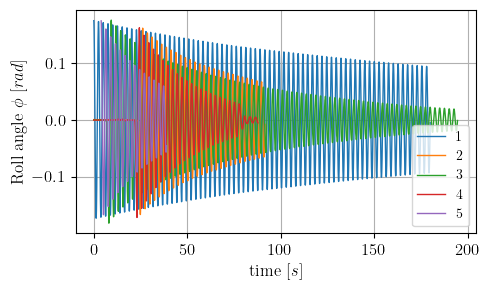

In [13]:
fig,ax=plt.subplots()
    
for file, row in content.iterrows():
    
    data = load(row['data file'])
    rolldecay.plot(data, y='phi', ax=ax, label=file);

ax.set_ylabel(r'Roll angle $\phi$ $[rad]$')
ax.set_xlabel(r'time $[s]$')
ax.grid(True)

<a id="fig_vel_acc"></a>

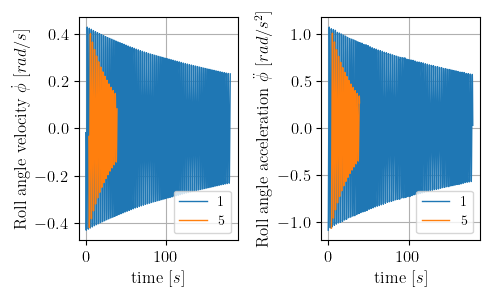

In [14]:
fig,axes=plt.subplots(ncols=2)
    
for file, row in content.iterrows():
    
    data = load(row['data file'])
    
    if 'phi1d' in data:
        rolldecay.plot(data, y='phi1d', ax=axes[0], label=file);
        
    if 'phi2d' in data:
        rolldecay.plot(data, y='phi2d', ax=axes[1], label=file);

        
axes[0].set_ylabel(r'Roll angle velocity $\dot\phi$ $[rad/s]$')
axes[0].set_xlabel(r'time $[s]$')
axes[0].grid(True)

axes[1].set_ylabel(r'Roll angle acceleration $\ddot\phi$ $[rad/s^2]$')
axes[1].set_xlabel(r'time $[s]$')
axes[1].grid(True)

# Analysis

## FNPF
The FNPF results have the benifit of having all the three states: $\phi$, $\dot{\phi}$ and $\ddot{\phi}$. This means that these time series can be inserted into the differential equation (Eq.[(see)](#eq_eq:roll_decay_equation_quadratic_A)) and the parameters of the model can be estimated using Ordinary Least Square method (OLS), solving the following regression:

<a id="eq_ols"></a>

In [15]:
 Equation(r'y = X \cdot \beta + \epsilon', label='ols')

<src.notebook_to_latex.Equation object>

where:
* $y$ is the dependent variable (also called *label*). 
* $\beta$ is a vector with the regressed parameters.
* $X$ is a matrix containing the independent variables (also called *features*).

The roll decay equation can be expressed as a linear regression with
* $y$ : the roll angle acceleration $\ddot{\phi}$ 
* $\beta$ : contains all the parameters : $B_1$, $B_2$, $C_1$...
* $X$ : contains all the time varying features such as: $| \dot{\phi} | \dot{\phi} $ etc.

So the roll acceleration is put on the left hand side:

<a id="eq_acceleration_equation_cubic"></a>

In [16]:
acceleration_equation_cubic = regression.get_acceleration(roll_decay_equation=equations.roll_decay_equation_cubic_A)
Equation(acceleration_equation_cubic, label='acceleration_equation_cubic')

<src.notebook_to_latex.Equation object>

In [17]:
acceleration_equation_cubic_x, eq_beta, eq_X, eq_y = regression.get_labels_and_features(acceleration_equation=acceleration_equation_cubic)

In [18]:
Equation(acceleration_equation_cubic_x,'acceleration_equation_cubic_x')

<src.notebook_to_latex.Equation object>

The equation for the acceleration Eq.[(above)](#eq_acceleration_equation_cubic) can now be rewritten as the linear regression in Eq.[(above)](#eq_ols), where:

In [19]:
Equation(eq_beta,'eq_beta')

<src.notebook_to_latex.Equation object>

In [20]:
Equation(eq_X, label='eq_X')

<src.notebook_to_latex.Equation object>

In [21]:
Equation(eq_y,'eq_y')

<src.notebook_to_latex.Equation object>

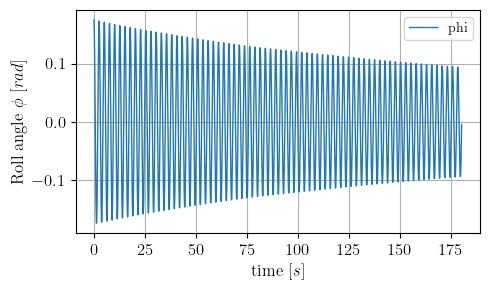

In [22]:
meta_data = content.loc[1]
data = load(meta_data['data file'])
renames = {
    'phi' : symbols.phi,
    'phi1d' : symbols.phi_dot,
    'phi2d' :symbols.phi_dot_dot,
}
#data.rename(columns=renames, inplace=True)
rolldecay.plot(data,y='phi');

In [23]:
data.head()

,phi,phi1d,phi2d,V1
Time,,,,
0.02,0.174388,-0.018087,-1.091653,3.082352e-11
0.04,0.173809,-0.039806,-1.082627,-3.701665e-05
0.06,0.172796,-0.061389,-1.074681,-7.304180e-05
0.08,0.171354,-0.082849,-1.065540,-1.121690e-04
0.10,0.169484,-0.104042,-1.056223,-1.409602e-04


In [24]:
X = regression.calculate_features(data=data, eq_X=eq_X, beta=eq_beta.rhs)

In [25]:
y = -data['phi2d']

The coefficients determined with Ordinary Least Square fit is shown in Tab.[(below)](#tab_parameters). The mean value of these coefficients are presented togehter with 5\% confidence level intervalls. 

In [26]:
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  phi2d   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.053e+08
Date:                Mon, 31 May 2021   Prob (F-statistic):                        0.00
Time:                        18:34:34   Log-Likelihood:                          42714.
No. Observations:                9000   AIC:                                 -8.542e+04
Df Residuals:                    8994   BIC:                                 -8.537e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B_3A           0.0981      0.013      7.444      0.000       0.072       0.124
C_3A          -5.5215      0.146    -37.941      0.000      -5.807      -5.236
C_5A         254.0934      4.678     54.312      0.000     244.923     263.264
B_2A          -0.0617      0.007     -8.508      0.000      -0.076      -0.047
B_1A           0.0163      0.001     16.878      0.000       0.014       0.018
C_1A           6.1162      0.001   6055.181      0.000       6.114       6.118
==============================================================================
Omnibus:                      496.814   Durbin-Watson:                   1.632
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1895.581
Skew:                          -0.126   Prob(JB):                         0.00
Kurtosis:                       5.234   Cond. No.                     4.97e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<a id="tab_parameters"></a>

In [27]:
df_results = src.visualization.regression.results_summary_to_dataframe(results)

df_table = df_results.reset_index()
df_table = df_table.round(decimals=3)

lt = LateXTable(df_table, rename={'index':'coeff','coeff':'mean'}, caption='Parameters estimation cubic model', label='parameters')
lt

coeff,mean,P>|t|,$conf_{lower}$,$conf_{higher}$
B_3A,0.098,0.0,0.072,0.124
C_3A,-5.522,0.0,-5.807,-5.236
C_5A,254.093,0.0,244.923,263.264
B_2A,-0.062,0.0,-0.076,-0.047
B_1A,0.016,0.0,0.014,0.018
C_1A,6.116,0.0,6.114,6.118


## Simulation
Fig.[(below)](#fig_sim_cubic) shows a simulation with the regressed parameters together with the original data from the FNPF simulations.

In [28]:
lambda_phi2d = lambdify(sp.solve(acceleration_equation_cubic, symbols.phi_dot_dot)[0])
df_results = src.visualization.regression.results_summary_to_dataframe(results)
df_sim = simulate(data=data, df_results=df_results, lambda_phi2d=lambda_phi2d)

<a id="fig_sim_cubic"></a>

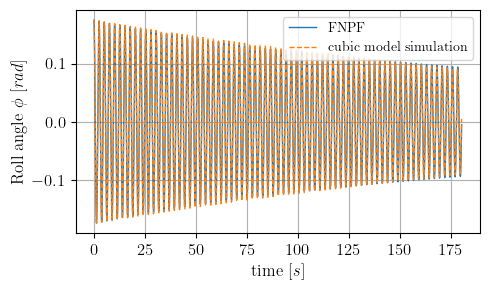

In [29]:
fig,ax=plt.subplots()
rolldecay.plot(data, y='phi', ax=ax, label='FNPF')
rolldecay.plot(df_sim, y='phi', ax=ax, label='cubic model simulation', style='--')
ax.legend();

In [30]:
parts = [
    symbols.phi_dot,
    symbols.phi,
]

xs2 = [sp.symbols(f'x_{i}') for i in range(1,len(parts)+1)]
y2_ = sp.symbols('y')
X2_ = sp.MatrixSymbol('X2', 1, len(xs2))
beta2_ = sp.MatrixSymbol('beta2', len(xs2), 1)

subs2 = {part:x for part,x in zip(parts,xs2)}

In [31]:
acceleration_equation_linear = acceleration_equation_cubic.subs([
    (B_2A,0),
    (B_3A,0),
    (C_3A,0),
    (C_5A,0),
    
])
Equation(acceleration_equation_linear, acceleration_equation_linear)

<src.notebook_to_latex.Equation object>

In [37]:

acceleration_equation_linear_x, eq_beta2, eq_X2, eq_y = regression.get_labels_and_features(acceleration_equation=acceleration_equation_linear)
Equation(acceleration_equation_linear_x,'acceleration_equation_cubic_x')

<src.notebook_to_latex.Equation object>

In [42]:
Equation(eq_beta2,'eq_beta2')

<src.notebook_to_latex.Equation object>

In [43]:
Equation(eq_X2,'eq_X2')

<src.notebook_to_latex.Equation object>

In [38]:
X2 = regression.calculate_features(data=data, eq_X=eq_X2, beta=eq_beta2.rhs)
model2 = sm.OLS(y,X2)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  phi2d   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.815e+08
Date:                Mon, 31 May 2021   Prob (F-statistic):                        0.00
Time:                        18:37:16   Log-Likelihood:                          40218.
No. Observations:                9000   AIC:                                 -8.043e+04
Df Residuals:                    8998   BIC:                                 -8.042e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B_1A           0.0072      0.000     55.819      0.000       0.007       0.007
C_1A           6.1007      0.000   1.91e+04      0.000       6.100       6.101
==============================================================================
Omnibus:                     1423.706   Durbin-Watson:                   0.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26669.321
Skew:                           0.012   Prob(JB):                         0.00
Kurtosis:                      11.433   Cond. No.                         2.47
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
df_results2 = src.visualization.regression.results_summary_to_dataframe(results2)

df_table = df_results2.reset_index()
df_table = df_table.round(decimals=3)

lt = LateXTable(df_table, rename={'index':'coeff','coeff':'mean'}, caption='Parameters estimation linear model', label='parameters')
lt

coeff,mean,P>|t|,$conf_{lower}$,$conf_{higher}$
B_1A,0.007,0.0,0.007,0.007
C_1A,6.101,0.0,6.1,6.101


<a id="fig_sim_linear"></a>

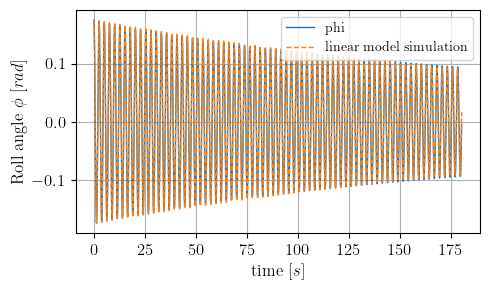

In [40]:

lambda_phi2d2 = lambdify(sp.solve(acceleration_equation_linear, symbols.phi_dot_dot)[0])

df_results2 = src.visualization.regression.results_summary_to_dataframe(results2)
df_sim2 = simulate(data=data, df_results=df_results2, lambda_phi2d=lambda_phi2d2)

fig,ax=plt.subplots()
rolldecay.plot(data, y='phi', ax=ax)
rolldecay.plot(df_sim2, y='phi', ax=ax, label='linear model simulation', style='--')
ax.legend();

In [41]:
r2_cubic = r2_score(y_true=data['phi'], y_pred=df_sim['phi'])
r2_linear = r2_score(y_true=data['phi'], y_pred=df_sim2['phi'])

Markdown(f"""The coefficient of determination $R^2$ is very similar between the cubic ({np.round(r2_cubic,3)}) and 
         the linear model  ({np.round(r2_linear,3)}), when comparing simulated roll signal with the corresponding data from FNPF.""") 

The coefficient of determination $R^2$ is very similar between the cubic (0.997) and 
         the linear model  (0.989), when comparing simulated roll signal with the corresponding data from FNPF.

## Model tests
The roll velocity and acceleration are missing from the model test data. This means that the regression approach as used for the FNPF data cannot be directly resused for this data. Instead the velocity and acceleration are first estimated using a Kalman Filter. 

In [ ]:
meta_data = content.loc[2]
data_raw = load(meta_data['data file'])
renames = {
    'phi' : symbols.phi,
    'phi1d' : symbols.phi_dot,
    'phi2d' :symbols.phi_dot_dot,
}
#data.rename(columns=renames, inplace=True)

index = data_raw['phi'].abs().idxmax()
data = data_raw.loc[index:].copy()

ax = rolldecay.plot(data_raw,y='phi', label='raw');
rolldecay.plot(data,y='phi', label='cut', style='--', ax=ax);

### Preprocessing with Kalman Filter

In [ ]:
from pykalman import KalmanFilter

t = data.index
dt = t[1] - t[0]

A = np.array([[1, dt, 0.5*(dt**2), 1/6*(dt**3)],
              [0,  1, dt         , 0.5*(dt**2)],
              [0,  0, 1          , dt],
              [0,  0, 0          , 1]])

kf = KalmanFilter(transition_matrices=A,
                  initial_state_mean = [0,0,0,0],
                  random_state=np.random.RandomState(0),
                  #transition_covariance=100 * np.eye(3),
                  #observation_covariance=100000 * np.eye(1),
                  #em_vars=[
                  #    'transition_covariance', 
                  #    #'observation_covariance', 
                  #    'initial_state_mean', 
                  #    'initial_state_covariance'
                  #    ],
                  )

observations = data['phi']
states_pred = kf.em(observations).smooth(observations)[0]

data['phi_filtered'] = states_pred[:,0]
data['phi1d'] = states_pred[:,1]
data['phi2d'] = states_pred[:,2]

In [ ]:
data['$\phi_{filtered}$'] = data['phi_filtered']
rolldecay.plot(data=data, y=['phi','$\phi_{filtered}$'])

rolldecay.plot(data=data, y='phi1d')
rolldecay.plot(data=data, y='phi2d')


In [ ]:
y = -data['phi2d']
X3 = regression.calculate_features(data=data, eq_X=eq_X, beta=beta)
model3 = sm.OLS(y,X3)
results3 = model3.fit()
results3.summary()

# Conclusions


# References
<div class="cite2c-biblio"></div>